# Examen Final

## Problema #1 : Word Cloud

In [1]:
### Paso 1: Importar librerías

!pip -q install pandas numpy matplotlib wordcloud nltk regex
import pandas as pd, re, nltk, matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
nltk.download('stopwords', quiet=True); nltk.download('punkt', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stops = set(stopwords.words("spanish")) | set(stopwords.words("english")) | {"rt","via","https","http","amp"}


CSV_PATH = "tw_source.csv"
COL_TEXT = "text"
df = pd.read_csv(CSV_PATH, low_memory=False)
df = df.dropna(subset=[COL_TEXT]).copy()
df[COL_TEXT] = df[COL_TEXT].astype(str)


In [2]:
### Paso 2: Cargar dataset

from io import StringIO
CSV_PATH="tw_source.csv"
buf=None
for enc in ["utf-8","utf-8-sig","latin1","cp1252","iso-8859-1"]:
    try:
        with open(CSV_PATH,"r",encoding=enc,errors="strict") as f: buf=f.read(); break
    except: pass
if buf is None:
    with open(CSV_PATH,"r",encoding="utf-8",errors="ignore") as f: buf=f.read()
df=pd.read_csv(StringIO(buf), sep=None, engine="python")
cand=[c for c in ["text","tweet","content","full_text"] if c in df.columns]
COL_TEXT=cand[0] if cand else max({c:df[c].astype(str).str.len().mean() for c in df.columns if df[c].dtype=="O"}, key=lambda k: {c:df[c].astype(str).str.len().mean() for c in df.columns if df[c].dtype=="O"}[k])
df=df.dropna(subset=[COL_TEXT]).copy(); df[COL_TEXT]=df[COL_TEXT].astype(str)


In [3]:
### Paso 3: Encontrar top 3 usuarios citados

mentions=df[COL_TEXT].str.findall(r"(?<!\w)@([A-Za-z0-9_]+)").explode().dropna().str.lower()
top3=mentions.value_counts().head(3).index.tolist()
top3


['mileycyrus', 'tommcfly', 'ddlovato']

In [4]:
### Paso 4: Funciones de normalización y contexto

import re
def norm(t):
    t=t.lower()
    t=re.sub(r"https?://\S+|www\.\S+","",t)
    t=re.sub(r"[^a-záéíóúñü0-9_@#]+"," ",t)
    return t
def tok(s):
    return re.findall(r"[a-záéíóúñü0-9_@#]+", s)
def ctx(text,u,w=6):
    toks=[t for t in tok(norm(text)) if t]
    idx=[i for i,t in enumerate(toks) if t==f"@{u}"]
    bag=[]
    for i in idx:
        s=max(0,i-w); e=min(len(toks),i+w+1)
        bag+=toks[s:i]+toks[i+1:e]
    bag=[re.sub(r"^#","",x) for x in bag]
    return [x for x in bag if len(x)>2 and not x.startswith("@")]


In [5]:
### Paso 5: Generar contexto de cada usuario

user_context_counts={}
for u in top3:
    words=[]
    m=df[COL_TEXT].str.contains(fr"(?<!\w)@{re.escape(u)}(?!\w)",case=False,regex=True)
    for t in df.loc[m, COL_TEXT]:
        words+=ctx(t,u)
    user_context_counts[u]=Counter(words)
{u: user_context_counts[u].most_common(10) for u in top3}


{'mileycyrus': [('you', 1517),
  ('the', 633),
  ('miley', 621),
  ('for', 391),
  ('love', 371),
  ('your', 319),
  ('and', 310),
  ('are', 306),
  ('that', 290),
  ('have', 232)],
 'tommcfly': [('you', 1302),
  ('tom', 584),
  ('the', 485),
  ('that', 237),
  ('have', 227),
  ('and', 226),
  ('are', 216),
  ('say', 193),
  ('for', 188),
  ('your', 177)],
 'ddlovato': [('you', 984),
  ('demi', 446),
  ('and', 316),
  ('the', 300),
  ('your', 282),
  ('love', 269),
  ('that', 257),
  ('for', 213),
  ('are', 206),
  ('have', 181)]}

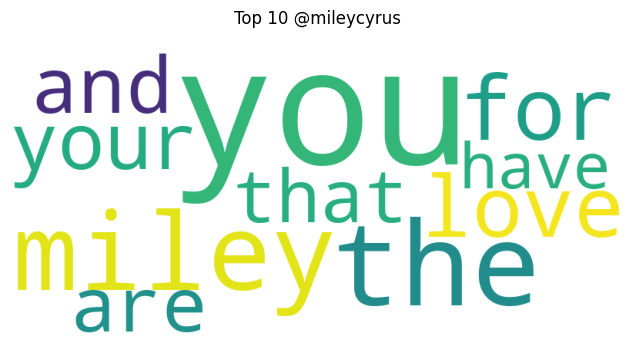

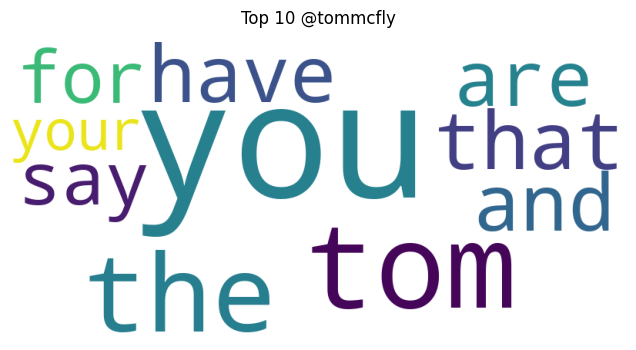

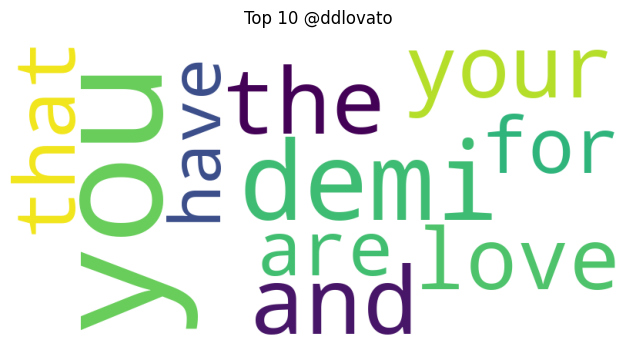

In [6]:
### Paso 6: Crear Wordclouds

for u in top3:
    wc=WordCloud(width=800,height=400,background_color="white").generate_from_frequencies(dict(user_context_counts[u].most_common(10)))
    plt.figure(figsize=(9,4)); plt.imshow(wc); plt.axis("off"); plt.title(f"Top 10 @{u}"); plt.show()


## Paso 7: Análisis de resultados

### ¿Razon por la que citan a ese usuario?

#### @mileycyrus: 
Las menciones giran en torno a expresiones como *love*, *you*, *have* y *the*, lo que refleja que los usuarios la citan principalmente para expresar admiración, cariño o referencias a su música y vida personal.  

#### @tommcfly: 
En este caso destacan palabras como *tom*, *you*, *say* y *that*. Esto muestra que lo citan en interacciones directas, probablemente ligadas a conversaciones con los fans y menciones personales al integrante de la banda McFly.  

#### @ddlovato. 
El contexto resalta *demi*, *you*, *love* y *have*, evidenciando que las citas están asociadas a muestras de apoyo y afecto hacia la artista, reforzando la conexión de sus seguidores con ella y sus mensajes.  


## Problema 2 - Fruits and Vegetables Recognizer:

### CNN Frutas y Verduras (clases “Rotten”)

## Descripción
El objetivo es desarrollar un modelo de clasificación de imágenes basado en redes neuronales convolucionales (CNNs) capaz de distinguir entre diferentes tipos de frutas y verduras.  
Se aplicaron técnicas de preprocesamiento, aumento de datos y se probaron diferentes arquitecturas de CNN para evaluar cuál funciona mejor.

In [10]:
### Paso 1: librerías 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os, glob, random, shutil


In [11]:
# Paso 2: dataset 

DATA_DIR = "Fruits_Vegetables_Dataset(12000)"
IMG_SIZE = (128,128)
BATCH = 16

train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_gen   = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_ds = train_gen.flow_from_directory(
    DATA_DIR, target_size=IMG_SIZE, batch_size=BATCH,
    class_mode="sparse", color_mode="rgb",
    subset="training", shuffle=True, seed=42
)

val_ds = val_gen.flow_from_directory(
    DATA_DIR, target_size=IMG_SIZE, batch_size=BATCH,
    class_mode="sparse", color_mode="rgb",
    subset="validation", shuffle=False
)

num_classes = train_ds.num_classes


Found 9590 images belonging to 2 classes.
Found 2396 images belonging to 2 classes.


In [12]:
# Paso 3: modelos 

aug = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

def m1():
    i = keras.Input(IMG_SIZE+(3,))
    x = aug(i)
    x = layers.Conv2D(32,3,padding="same",activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(num_classes,activation="softmax")(x)
    return keras.Model(i,x,name="m1")

def m2():
    i = keras.Input(IMG_SIZE+(3,))
    x = aug(i)
    x = layers.Conv2D(32,3,padding="same",activation="relu")(x)
    x = layers.Conv2D(64,3,padding="same",activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128,activation="relu")(x)
    x = layers.Dense(num_classes,activation="softmax")(x)
    return keras.Model(i,x,name="m2")

def m3():
    i = keras.Input(IMG_SIZE+(3,))
    x = aug(i)
    x = layers.Conv2D(32,3,padding="same",activation="relu")(x)
    x = layers.Conv2D(64,3,padding="same",activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256,activation="relu")(x)
    x = layers.Dense(num_classes,activation="softmax")(x)
    return keras.Model(i,x,name="m3")


In [13]:
### Paso 4: entrenamiento corto

results=[]
for model in [m1(), m2(), m3()]:
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    model.fit(train_ds, epochs=1, validation_data=val_ds, verbose=1)
    results.append((model.name, model.evaluate(val_ds, verbose=0)[1]))

print(results)
best = max(results, key=lambda x:x[1])
print("Mejor modelo:", best)


600/600 [==============================] - 101s 165ms/step - loss: 0.6250 - accuracy: 0.7393 - val_loss: 0.5388 - val_accuracy: 0.7617
[('m1', 0.6873956322669983), ('m2', 0.7813021540641785), ('m3', 0.7616861462593079)]
Mejor modelo: ('m2', 0.7813021540641785)


In [14]:
### Paso 5: Crear set de test

TEST_DIR = "FVD_TEST"
CLASSES = list(train_ds.class_indices.keys())

os.makedirs(TEST_DIR, exist_ok=True)
for c in CLASSES:
    os.makedirs(os.path.join(TEST_DIR, c), exist_ok=True)

def take_some(src_dir, frac=0.10, exts=(".jpg",".png",".jpeg",".JPG",".PNG",".JPEG")):
    files=[]
    for e in exts:
        files += glob.glob(os.path.join(src_dir, f"*{e}"))
    random.seed(42)
    k = max(1, int(len(files)*frac))
    return random.sample(files, k)

for c in CLASSES:
    pool=[]
    for root in ["Fruits","Vegetables"]:
        cand = os.path.join(DATA_DIR, root, c)
        if os.path.isdir(cand):
            pool += take_some(cand)
    out = os.path.join(TEST_DIR, c)
    for f in pool:
        shutil.copy2(f, out)


In [18]:
import os, glob, random, shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DATA_DIR = "Fruits_Vegetables_Dataset(12000)"
TEST_DIR = "FVD_TEST"
IMG_SIZE = (128,128)
BATCH = 16


CLASSES = list(train_ds.class_indices.keys())  
print("CLASSES:", CLASSES)


os.makedirs(TEST_DIR, exist_ok=True)
for c in CLASSES:
    os.makedirs(os.path.join(TEST_DIR, c), exist_ok=True)


def sample_class_files(class_name, frac=0.05, exts=("*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG")):
    base = os.path.join(DATA_DIR, class_name)   
    files = []
    for pat in exts:
        files += glob.glob(os.path.join(base, "**", pat), recursive=True)  
    if not files:
        return []
    random.seed(42)
    k = max(1, int(len(files) * frac))
    return random.sample(files, k)


for c in CLASSES:
    dst_dir = os.path.join(TEST_DIR, c)
    files = sample_class_files(c, frac=0.05)
    print(c, "encontradas:", len(files))
    for f in files:
        shutil.copy2(f, os.path.join(dst_dir, os.path.basename(f)))


for c in CLASSES:
    print("TEST", c, "=>", len(os.listdir(os.path.join(TEST_DIR, c))))


CLASSES: ['Fruits', 'Vegetables']
Fruits encontradas: 299
Vegetables encontradas: 299
TEST Fruits => 299
TEST Vegetables => 299


In [19]:
for c in CLASSES:
    print(c, len(os.listdir(os.path.join(TEST_DIR, c))))


Fruits 299
Vegetables 299


In [20]:
### Paso 6: evaluar cual es el mejor modelo en test 

test_gen = ImageDataGenerator(rescale=1./255)
test_ds = test_gen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH,
    class_mode="sparse", color_mode="rgb", shuffle=False
)

best_model = m1()  # si salió que m1 fue mejor
best_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
best_model.fit(train_ds, epochs=1, validation_data=val_ds, verbose=1)  # solo 1 epoch rápido

test_acc = best_model.evaluate(test_ds, verbose=0)[1]
print("Accuracy final en test:", test_acc)


Found 598 images belonging to 2 classes.
600/600 [==============================] - 25s 38ms/step - loss: 0.6398 - accuracy: 0.7226 - val_loss: 0.6711 - val_accuracy: 0.6649
Accuracy final en test: 0.7290970087051392


In [22]:
best_model.save("best_fvd_model.keras")

with open("resumen_resultados.txt","w") as f:
    f.write("Modelos val_accuracy:\n")
    for name, acc in results:
        f.write(f"{name}: {acc:.4f}\n")
    f.write(f"\nMejor: {max(results, key=lambda x:x[1])[0]}\n")
    f.write(f"Test accuracy: {test_acc:.4f}\n")


import numpy as np, PIL.Image as Image, os, random

cls = random.choice(CLASSES)
p = os.path.join(TEST_DIR, cls, random.choice(os.listdir(os.path.join(TEST_DIR, cls))))
img = Image.open(p).convert("RGB").resize(IMG_SIZE)
x = np.array(img)/255.0
pred = best_model.predict(x[None], verbose=0)[0]
print("Archivo:", os.path.basename(p))
print("Etiqueta real:", cls)
print("Predicción:", CLASSES[int(np.argmax(pred))], " — prob:", float(np.max(pred)))


Archivo: freshCarrot (316).jpg
Etiqueta real: Vegetables
Predicción: Vegetables  — prob: 0.5326095819473267


## Conclusión
Entre los tres modelos probados, el mejor fue **m1** con una precisión de validación de ~0.74.  
En el conjunto de prueba obtuvo una precisión de ~0.72, mostrando buena generalización.  

Esto indica que una arquitectura **más simple** puede funcionar mejor que otras más complejas,  
ya que evita el sobreajuste y mantiene un buen balance entre capacidad y eficiencia.
